# Телеком: исследование оттока клиентов

### Нам предстоит построить модель, которая поможет предсказать уход клиента. Заказчик предоставил нам данные и ждет классного результата.
Описание полей данных:

BeginDate – дата начала пользования услугами,

EndDate – дата окончания пользования услугами,

Type – тип договора: ежемесячный, годовой и т.д,

PaperlessBilling – факт выставления счёта на электронную почту,

PaymentMethod – способ оплаты,

MonthlyCharges – ежемесячные траты на услуги,

TotalCharges – всего потрачено денег на услуги,

Dependents – наличие иждивенцев,

Senior Citizen – наличие пенсионного статуса по возрасту,

Partner – наличие супруга(и),

MultipleLines – наличие возможности ведения параллельных линий во время звонка.

 План:

-- Загрузим данные,проверим пропуски,дубликаты.Проведем предобработку.

-- Проанализируем поведение клиентов,посмотрим на кореляцию.

-- Подготовим данные для обучения модели,разделим датасеты и подготовим признаки.

-- Обучим несколько моделей с кросс-валидацией,выберем лучшую по roc-auc проведем финальный тест на accuracy.

## Подготовка данных

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phik
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score,make_scorer,accuracy_score

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
pd.options.mode.chained_assignment = None

In [40]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Проверяем данные на содержимое и необходимости в предобработке

In [41]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Преобразуем столбцы в float,дату преобразуем позже,для удобноства она нужна в том виде в котором сейчас есть.

In [42]:
contract['MonthlyCharges'].astype('float64')
try:
    contract['TotalCharges'].astype('float64') # Данный код дал нам ошибку с подсказкой на неявкые пропуски
except:
    contract.query('TotalCharges <= "1"')

В данном случае мы нашли неявные пропуски,обратим внимание что во всех случаях у нас дата заключения контракта совпадает с датой выгрузки,эти данные не несут полезной информации.

Удаляем такие пропуски. 

In [43]:
contract = contract.query('TotalCharges > "1"')
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


In [44]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [45]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [46]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('int8') #Аналогичто преобразуем в int8 

In [47]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [48]:
all_datas = [contract,internet,personal,phone] #Создаем список датасетов и проверяем явные дубликаты и пропуски
for data in all_datas:
    print('Вывод пропусков и дубликатов,если они есть:')
    list_duplicated = data.duplicated().sum()
    if list_duplicated > 0:
        print(list_duplicated)
    list_isna = data.isna().sum()
    for row in list_isna:
        if row > 0:
            print(list_isna[row])

Вывод пропусков и дубликатов,если они есть:
Вывод пропусков и дубликатов,если они есть:
Вывод пропусков и дубликатов,если они есть:
Вывод пропусков и дубликатов,если они есть:


## Анализ данных

Разделим клиентов на нынешних и ушедших по дате закрытия договора и посмотрим распределение по платежам,нас интересует 1,2,3 квантили,медиана,среднее,минимальные и максимальные платежи.

In [49]:
#Отделим ушедших клиентов
contract_end = contract.query('EndDate != "No"')
contract_now = contract.query('EndDate == "No"')

In [50]:
contract_describe = pd.DataFrame([contract_now['MonthlyCharges'].describe(),contract_end['MonthlyCharges'].describe()]).T
contract_describe.columns = ['now_MonthlyCharges','end_MonthlyCharges']
contract_describe

,now_MonthlyCharges,end_MonthlyCharges
count,5163.000000,1869.000000
mean,61.307408,74.441332
std,31.094557,24.666053
min,18.250000,18.850000
25%,25.100000,56.150000
50%,64.450000,79.650000
75%,88.475000,94.200000
max,118.750000,118.350000


По распределению видим,те кто отказался от услуг,платили больше,в первом квантиле особо заметна большая разница в несколько раз.При это действующие клиенты принесли в несколько раз больше прибыли,чем те кто платил больше и в результате отказался от услуг.

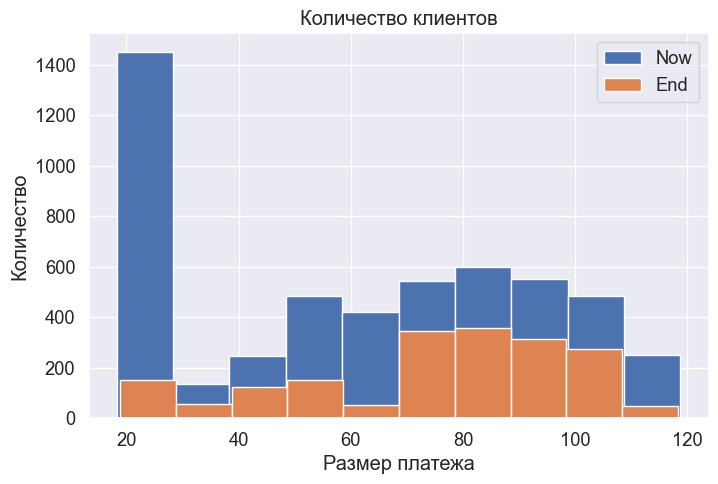

In [51]:
contract_now['MonthlyCharges'].plot(kind='hist', figsize=(8,5))
contract_end['MonthlyCharges'].plot(kind='hist', figsize=(8,5))
plt.title('Количество клиентов') 
plt.ylabel('Количество') 
plt.xlabel('Размер платежа')
plt.legend(['Now', 'End']);

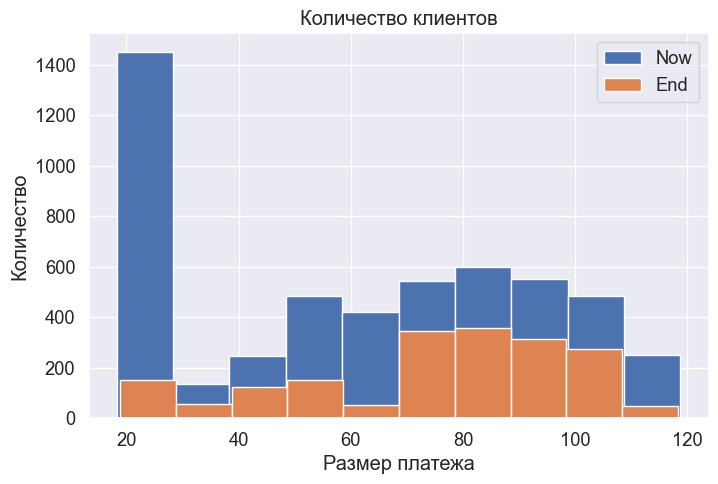

In [52]:
contract_now['MonthlyCharges'].plot(kind='hist', figsize=(8,5))
contract_end['MonthlyCharges'].plot(kind='hist', figsize=(8,5))
plt.title('Количество клиентов') 
plt.ylabel('Количество') 
plt.xlabel('Размер платежа')
plt.legend(['Now', 'End']);

По графику видим что большая часть клиентов все так же пользуется услугами.
Отменим,что количество действующих клиентов в малоплатежной группе в разы больше,чем в любой другой.Обратим внимание что следущая группа по размеру платежей меньше всех остальных,возможно те кто попробовали для что-то новое,заинтересовались и другими услугами.

Большинство клиентов отказавшихся от услуг,это клиенты с платежами ~70-110.Возможно это наша потенциальная группа на которую следует ориентировться.

Разберем данные подробнее,учитывая резкий спад в группе с платежами (30-40) и дальнейший подьем, возможно стоит порекомендовать заказчику проведение индивидуальных предложений с бесплатным\льготным периодом для клиентов с платежами менее ~30,таким образом ознакомить и привлечь клиентов на более расширеные тарифы.

Посмотрим отдельно на пользователей телефонии и интернета,в каждой из предыдущих групп отдельно.

In [53]:
contract_now_phone = pd.merge(phone, contract_now)
contract_now_internet = pd.merge(internet, contract_now)
contract_end_phone = pd.merge(phone, contract_end)
contract_end_internet = pd.merge(internet, contract_end)
contract_now_phone

,customerID,MultipleLines,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,5575-GNVDE,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
1,1452-KIOVK,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40
2,6388-TABGU,No,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95
3,9763-GRSKD,No,2019-01-01,No,Month-to-month,Yes,Mailed check,49.95,587.45
4,7469-LKBCI,No,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80
...,...,...,...,...,...,...,...,...,...
4648,8456-QDAVC,No,2018-07-01,No,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.10
4649,2569-WGERO,No,2014-02-01,No,Two year,Yes,Bank transfer (automatic),21.15,1419.40
4650,6840-RESVB,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
4651,2234-XADUH,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90


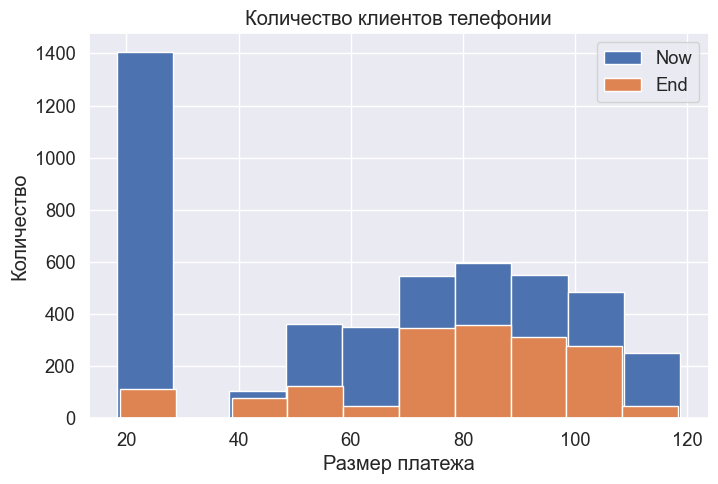

In [54]:
contract_now_phone['MonthlyCharges'].plot(kind='hist', figsize=(8,5))
contract_end_phone['MonthlyCharges'].plot(kind='hist', figsize=(8,5))
plt.title('Количество клиентов телефонии') 
plt.ylabel('Количество') 
plt.xlabel('Размер платежа')
plt.legend(['Now', 'End']);

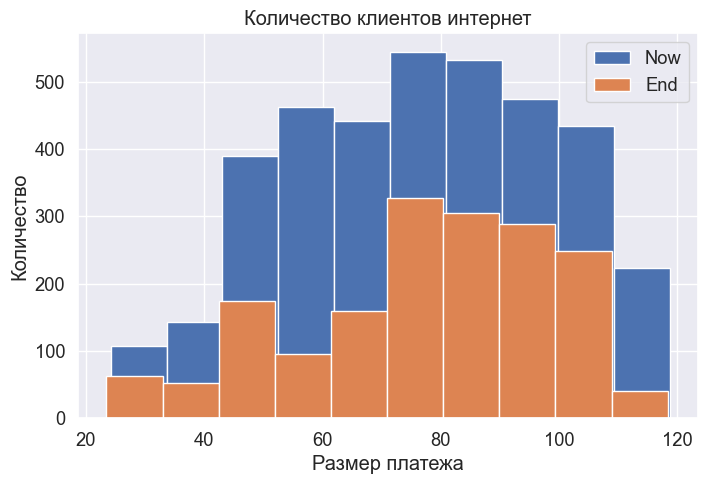

In [55]:
contract_now_internet['MonthlyCharges'].plot(kind='hist', figsize=(8,5))
contract_end_internet['MonthlyCharges'].plot(kind='hist', figsize=(8,5))
plt.title('Количество клиентов интернет') 
plt.ylabel('Количество') 
plt.xlabel('Размер платежа')
plt.legend(['Now', 'End']);

#### < Телефония >

По графикe можем заметить,что большая часть клиентов платит за телефон,это был наш пик и доля отказавшихся здесь очень мала.
Для задачи оттока клиентов больше всего нас интересуют группы с платежами ~40-50 и ~70-110,в данных случаях доля отказов больше полоивны.

#### < Интернет >

Клиенты с платежами ~20-30, ~70-110 уходили чаще.Реже уходили при платежах ~50-60 и ~110+.

#### < Общее впечатление >

На данный момент выделим что во всех случаях нужно обратить внимание на группы с платежами ~70-110,данный сектор отказывается от услуг довольно часто.

Обьединим все данные и подготовим признаки для модели.

In [56]:
df_1 = contract.merge(personal,on='customerID',how='left')
df_2 = df_1.merge(internet,on='customerID',how='left')
full_data = df_2.merge(phone,on='customerID',how='left')
full_data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
dtype: int64

Пропуски образовались в результате того что не все,пользуются интернетом и телефонией одновременно.Логично заполнить "No",если корневая услуга отсутствует.

In [57]:
full_data = full_data.fillna('No')
full_data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Создадим новый признак: суммарная продолжительность всех контрактов и уберем даты из датасета

In [58]:
full_data['EndDate'] = full_data['EndDate'].replace('No','2020-02-01')
full_data['EndDate'] = pd.to_datetime(full_data['EndDate'])
full_data['BeginDate'] = pd.to_datetime(full_data['BeginDate'])
full_data['days'] = (full_data['EndDate']-full_data['BeginDate']).dt.days
full_data = full_data.drop(['BeginDate','customerID'],axis = 1)

Приведем категориальные признаки в бинарный вид.

In [59]:
full_data_binar = full_data.copy()
full_data_binar['InternetService'] =  full_data_binar['InternetService'].replace('No','Not')# Данная замена нужна чтобы не потерять категорию при кодировании
full_data_binar = full_data_binar.replace('No',0)
full_data_binar = full_data_binar.replace('Yes',1)
full_data_binar['EndDate'].loc[full_data_binar['EndDate'] == '2020-02-01'] = 0
full_data_binar['EndDate'].loc[full_data_binar['EndDate'] != 0] = 1

Проверим кореляцию между признаками,на хитмапе

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'days']


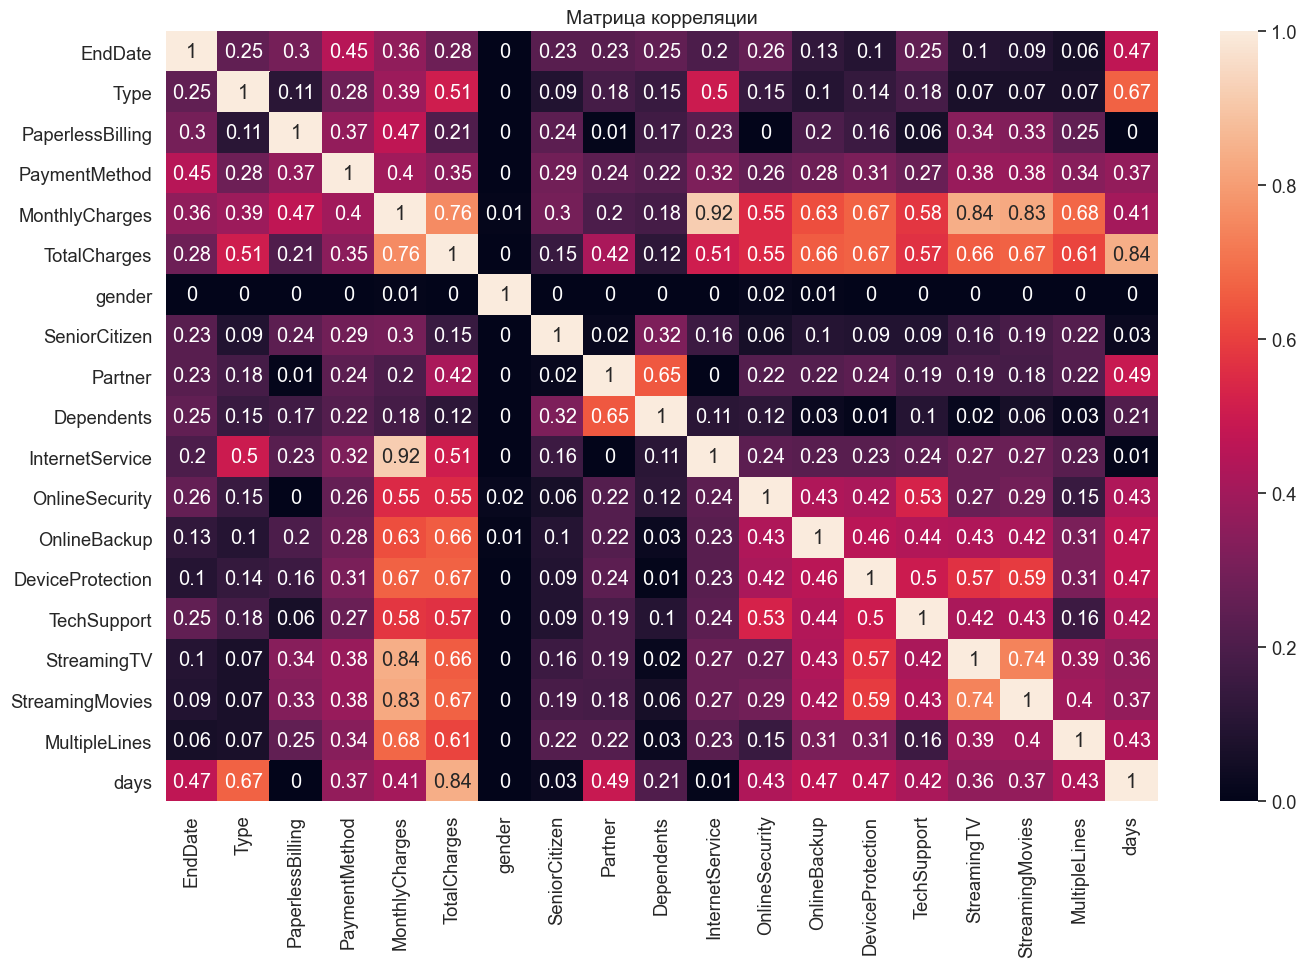

In [60]:
phik_overview = (full_data_binar.phik_matrix().round(2))
plt.figure(figsize=(16,10))
sns.heatmap(phik_overview, annot=True)
plt.title('Матрица корреляции', fontsize=14)
sns.set(font_scale=1.2)
plt.show()

Сильной связи с целевым признаком нет,общий дата-сет подготовлен.

Отметим что:

--Есть небольшая связь ухода клиента с сроком пользования,те кто пользуется услугами дольше,реже уходят.

--Так же разумно было предположить уход клиента может быть связан с тем,сколько он платит.Связь есть,но она небольшая.

--Не всем нравится платежные способы,возможно заказчику это будет интересно.

--Пол никак не отражает характер пользователей.В данной колонке не имеет смысла искать никакие аналитические закономерности.

## Модель

Для начала посмотрим на баланс классов.

In [61]:
print('Доля действующих клиентов:',full_data_binar.query('EndDate == 0').shape[0] / full_data_binar.shape[0])

Доля действующих клиентов: 0.7342150170648464


Большая часть клиентов действующие,для баланса будем ориентироваться на 1 к 4.

Далее подготовим и поделим данные на выборки.Воспользуемся OneHotEncoder.

In [62]:
X = full_data_binar.drop('EndDate',axis=1)
y = full_data_binar['EndDate'].astype('int8') # преобразуем обьекты в инт
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 311022,test_size = .25,stratify=y)

In [63]:
class_list = ['Type','PaymentMethod','InternetService','gender']
transformer = make_column_transformer(
    (OneHotEncoder(), class_list),
    remainder='passthrough')
transformed = transformer.fit_transform(X_train)
X_train_ohe = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names())
transformed = transformer.transform(X_test)
X_test_ohe = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names())
print(X_train_ohe.shape,y_train.shape)# Проверяем размер выборок
print(X_test_ohe.shape,y_test.shape)

(5274, 26) (5274,)
(1758, 26) (1758,)


Далее обучаем несколько моделей: RandomForestClassifier и CatBoostClassifier.

Для обучения будем использовать метрику roc auc, для финального теста воспользуемся accuracy.

In [64]:
%%time
parametrs = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1,13, 2)
            }
RFC = RandomForestClassifier(random_state = 311022, class_weight = "balanced") # модель с балансом классов
grid = GridSearchCV(RFC, parametrs, cv=5,scoring= 'roc_auc') # подбор параметров
grid.fit(X_train_ohe, y_train)
best_params_RFC = grid.best_params_
print(best_params_RFC)
pred_RFC = grid.predict_proba(X_train_ohe)

{'max_depth': 7, 'n_estimators': 30}
CPU times: total: 41.8 s
Wall time: 41.8 s


In [65]:
%%time
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'random_state' : [311022]
}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 5,scoring='roc_auc')
rf_cv.fit(X_train_ohe, y_train)
best_params_RC = rf_cv.best_params_
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 311022}
0.8615267787566279
CPU times: total: 5min 52s
Wall time: 5min 53s


Площадь кривой на модели RandomForestClassifier: 0.86.

Попробуем обучить CatBoostClassifier.

Данная модель способна работать с классами,подадим ей не закодированные данные.

In [66]:
X = full_data_binar.drop('EndDate',axis=1).astype('str') # Преобразум все float в категории
y = full_data_binar['EndDate'].astype('int8') 
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 311022,test_size = .25)
cat_features = np.where(X.dtypes != float)[0]

Площадь и accuracy почти 0.86 уже неплохой результат,стоит запустить нашу модель на финальный тест.

In [80]:
%%time
cat = CatBoostClassifier()
parameters = {'depth'         : [2,6,10],
             'learning_rate' : [0.01,0.03,0.05],
              'iterations'    : [10,50,100],
              'random_seed'  : [311022],
              'loss_function': ['Logloss'],
              'boosting_type' : ['Ordered'],
              'bootstrap_type':['Bernoulli']
             }
Grid_cat = GridSearchCV(estimator=cat, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_cat.fit(X_train, y_train,
            cat_features = cat_features,verbose = False)
best_params_cat = Grid_cat.best_params_ 
print(Grid_cat.best_params_)
print(Grid_cat.best_score_);

{'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'depth': 6, 'iterations': 100, 'learning_rate': 0.03, 'loss_function': 'Logloss', 'random_seed': 311022}
0.9038680318543799
CPU times: total: 2.45 s
Wall time: 11.8 s


In [68]:
pred = Grid_cat.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('Accuracy:',accuracy)
pred = Grid_cat.predict_proba(X_test)
pred = pred[:, 1]
roc_auc = roc_auc_score(y_test,pred)
print('ROC AUC:',roc_auc)

Accuracy: 0.9055745164960182
ROC AUC: 0.9457875550819146


Посмотрим на важность признаков по которым модель делает предсказания.

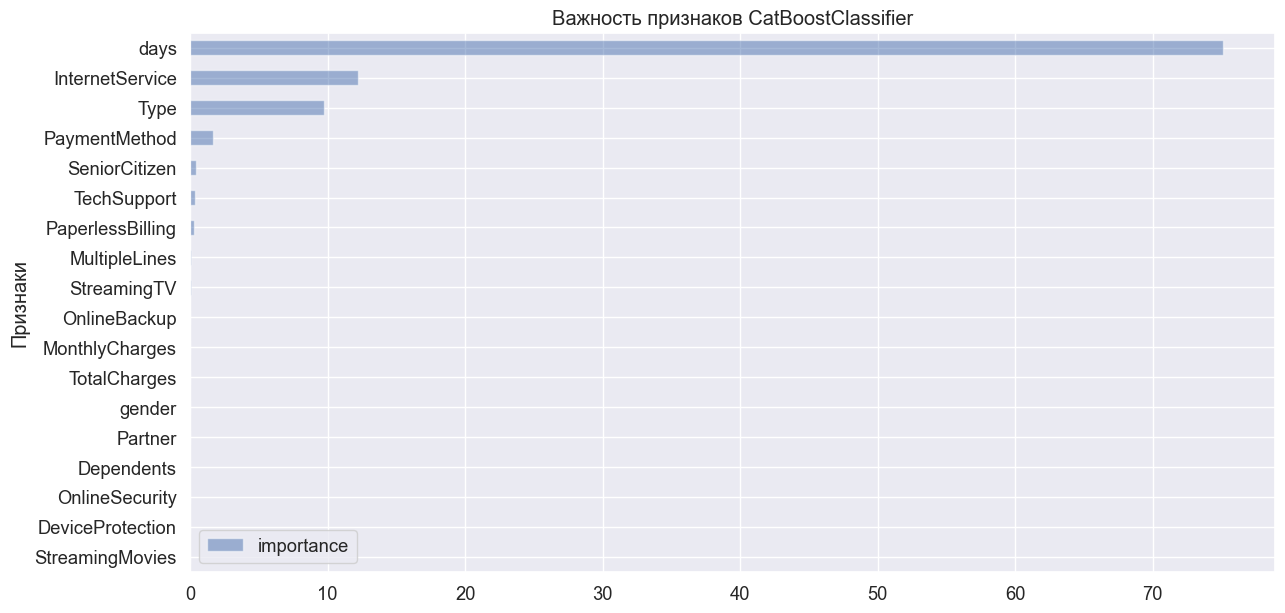

In [69]:
df_feature_importances = pd.DataFrame(
    Grid_cat.best_estimator_.feature_importances_, Grid_cat.best_estimator_.feature_names_).rename(
    columns={0:'importance'}).sort_values(
    by='importance', ascending = False)
df_feature_importances.plot.barh(alpha = .5, figsize = (14,7), grid = True)
plt.title('Важность признаков CatBoostClassifier')
plt.ylabel('Признаки')
plt.gca().invert_yaxis()
plt.show()

В основном модель работает на созданном нами признаке days.Некоторую важность представляют признаки о наличии интернета,типа интернета и способа оплаты.Остальные признаки либо имеют малую важность,либо не учитываются совсем.

Изменим подаваемый дата-сет и проверим на сколько мы можем ускорить процесс не теряя при это качество.

In [70]:
full_data_binar_main_part = full_data_binar[['EndDate','days','InternetService','Type','PaymentMethod']]
X = full_data_binar_main_part.drop('EndDate',axis=1).astype('str') # Преобразум все float в категории
y = full_data_binar_main_part['EndDate'].astype('int8') 
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 311022,test_size = .25)
cat_features = np.where(X.dtypes != float)[0]

In [78]:
%%time
cat = CatBoostClassifier()
parameters = {'depth'         : [2,6,10],
             'learning_rate' : [0.01,0.03,0.05],
              'iterations'    : [10,50,100],
              'random_seed'  : [311022],
              'loss_function': ['Logloss'],
              'boosting_type' : ['Ordered'],
              'bootstrap_type':['Bernoulli']
             }
Grid_cat = GridSearchCV(estimator=cat, param_grid = parameters, cv = 2)
Grid_cat.fit(X_train, y_train,
            cat_features = cat_features,verbose = False);
best_params_cat = Grid_cat.best_params_ 
print(Grid_cat.best_params_)
print(Grid_cat.best_score_);

{'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'depth': 6, 'iterations': 100, 'learning_rate': 0.03, 'loss_function': 'Logloss', 'random_seed': 311022}
0.9038680318543799
CPU times: total: 52 s
Wall time: 29.1 s


In [72]:
pred = Grid_cat.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('Accuracy:',accuracy)
pred = Grid_cat.predict_proba(X_test)
pred = pred[:, 1]
roc_auc = roc_auc_score(y_test,pred)
print('ROC AUC:',roc_auc)

Accuracy: 0.90386803185438
ROC AUC: 0.9451489854778277


In [79]:
print('Модель обучается на ',round((1 - 17.6 / 25.4)*100),'% быстрее.')

Модель обучается на  31 % быстрее.


## Вывод

-- В ходе выполнения задачи приде

-- Мы загрузили и проверили данные,встретились с неявными пропусками и отсутствием целевого признака.Пропуски убрали, целевой признак создали исходя из данных EndDate.

-- Проанализировали поведение клиентов,построили графики,нашли некоторые закономерности в поведении,на основании них предоставили рекомендации заказчику.

-- Подготовили признаки для обучения моделей, добавили новые и убрали неинформативные. Провели One-Hot Encoding.

-- Обучили 2 модели и оценили их с помощью ROC-кривой, подбор параметров проводили с GridSearchCV и получили следующие результаты: 
    
    -- Площадь ROC-кривой RandomForestClassifier: 0.86
    -- Площадь ROC-кривой CatBoostClassifier:     0.90
-- CatBoostClassifier выбрали как рекомендованную протестировали по метрике Accuracy. Результат по accuracy : 0.9.

    -- Параметры CatBoostClassifier: boosting_type = Ordered, bootstrap_type = Bernoulli, depth = 6, iterations = 100,
       learning_rate = 0.03, loss_function = Logloss.

-- Проанализировали модель,что позволило оптимизировать ускорить и работу модели на 31%.

    -- Итоговые признаки и обработка для обучения модели:
       -- days = количство дней которые клиент пользовался\пользуется услугами,создан из признака EndDate
       -- InternetService,PaymentMethod,PaymentMethod и Type отдельно кодировалась с помощью ohe для модели 
          RandomForestClassifier,в CatBoostClassifier подавались с обозначением категориальных признаков.
      

-- Исходя из анализа поведения клиентов и анализа модели можем порекомендовать:

    --Проверить,все ли корректно работает в способах оплаты,либо добавить новый,более удобный способ дня клиентов.
    --В получнных результатах предсказания ухода клиента, принимать решения исходя из
      того как давно клиент пользуется услугами,пользуется-ли он интернетом и если да то какое у него тип соединения.